# Hyperparameter Fitting (Empirical Bayes) Animated

In [1]:
import matplotlib as mpl; mpl.use('pgf')

In [2]:
%matplotlib inline

In [3]:
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from collections import defaultdict

from matplotlib import animation
from IPython.display import HTML
from etudes.gaussian_processes import gp_sample_custom, dataframe_from_gp_samples

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
golden_ratio = 0.5 * (1 + np.sqrt(5))
golden_size = lambda width: (width, width / golden_ratio)

In [5]:
width = 10

rc = {
    "figure.figsize": golden_size(width),
    "text.usetex": True,
}

sns.set(context="notebook", style="ticks", palette="colorblind", font="serif", rc=rc)

In [6]:
# shortcuts
tfd = tfp.distributions
kernels = tfp.math.psd_kernels

# constants
n_features = 1 # dimensionality
n_index_points = 256 # nbr of index points
n_samples = 8 # nbr of GP prior samples
jitter = 1e-6
kernel_cls = kernels.ExponentiatedQuadratic

num_epochs = 250

seed = 42 # set random seed for reproducibility
random_state = np.random.RandomState(seed)

# index points
X_q = np.linspace(-1.0, 1.0, n_index_points).reshape(-1, n_features)

# kernel specification
amplitude_grid, length_scale_grid = np.ogrid[5e-2:4.0:100j, 1e-5:5e-1:100j]
kernel_grid = kernel_cls(amplitude=amplitude_grid, length_scale=length_scale_grid)

## Synthetic dataset

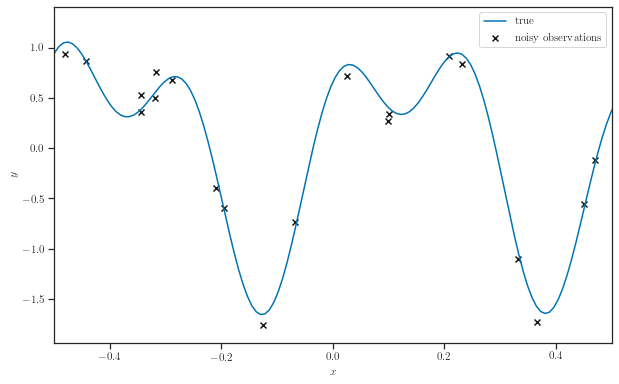

In [7]:
n_train = 20 # nbr training points in synthetic dataset
observation_noise_variance = 1e-1

f = lambda x: np.sin(12.0*x) + 0.66*np.cos(25.0*x)

X = random_state.rand(n_train, n_features) - 0.5
eps = observation_noise_variance * random_state.randn(n_train, n_features)
Y = np.squeeze(f(X) + eps)

fig, ax = plt.subplots()

ax.plot(X_q, f(X_q), label="true")
ax.scatter(X, Y, marker='x', color='k', label="noisy observations")

ax.legend()

ax.set_xlim(-0.5, 0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

## Log marginal likelihood

In [8]:
gp_grid = tfd.GaussianProcess(
    kernel=kernel_grid,
    index_points=X,
    observation_noise_variance=observation_noise_variance
)
nll_grid = - gp_grid.log_prob(Y)

with tf.Session() as sess:
    nll_grid_value = sess.run(nll_grid)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


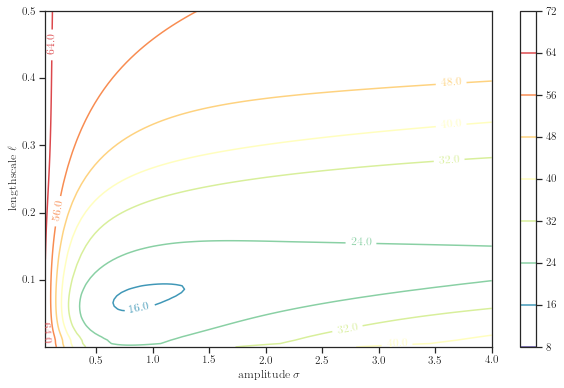

In [9]:
_amplitude_grid, _length_scale_grid = np.broadcast_arrays(amplitude_grid, length_scale_grid)

fig, ax = plt.subplots()

contours = ax.contour(_amplitude_grid, _length_scale_grid, nll_grid_value, cmap="Spectral_r")

fig.colorbar(contours, ax=ax)
ax.clabel(contours, fmt='%.1f')

ax.set_xlabel(r"amplitude $\sigma$")
ax.set_ylabel(r"lengthscale $\ell$")

plt.show()

## Empirical Bayes (maximizing the log marginal likelihood)

In [10]:
amplitude = tf.exp(tf.Variable(np.float64(0)), name='amplitude')
length_scale = tf.exp(tf.Variable(np.float64(-1)), name='length_scale')
observation_noise_variance = tf.exp(tf.Variable(np.float64(-5)), name='observation_noise_variance')
kernel = kernel_cls(amplitude=amplitude, length_scale=length_scale)
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=X,
    observation_noise_variance=observation_noise_variance
)

In [11]:
nll = - gp.log_prob(Y)
nll

<tf.Tensor 'Neg_1:0' shape=() dtype=float64>

In [12]:
optimizer = tf.train.AdamOptimizer(learning_rate=.05, beta1=.5, beta2=.99)
optimize = optimizer.minimize(nll)

In [13]:
history = defaultdict(list)

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    for i in range(num_epochs):
        (_, nll_value, amplitude_value, length_scale_value, 
         observation_noise_variance_value) = sess.run([optimize, nll, amplitude, length_scale, observation_noise_variance])
        history["nll"].append(nll_value)
        history["amplitude"].append(amplitude_value)
        history["length_scale"].append(length_scale_value)
        history["observation_noise_variance"].append(observation_noise_variance_value)

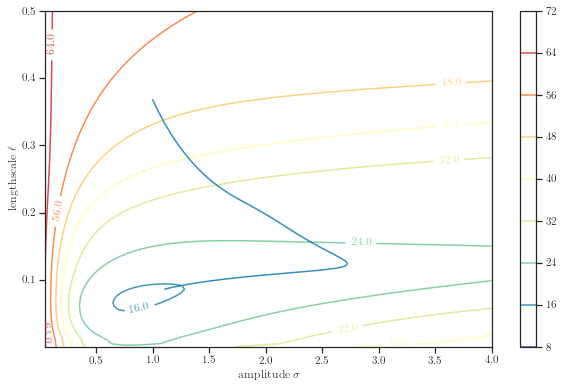

In [14]:
fig, ax = plt.subplots()

contours = ax.contour(_amplitude_grid, _length_scale_grid, nll_grid_value, cmap="Spectral_r")

sns.lineplot(x='amplitude', y='length_scale', 
             sort=False, data=pd.DataFrame(history), alpha=0.8, ax=ax)

fig.colorbar(contours, ax=ax)
ax.clabel(contours, fmt='%.1f')

ax.set_xlabel(r"amplitude $\sigma$")
ax.set_ylabel(r"lengthscale $\ell$")

plt.show()

## GP posterior predictive animated 

In [15]:
kernel_history = kernel_cls(amplitude=history.get("amplitude"), length_scale=history.get("length_scale"))
gprm_history = tfd.GaussianProcessRegressionModel(
    kernel=kernel_history, index_points=X_q, observation_index_points=X, observations=Y,
    observation_noise_variance=history.get("observation_noise_variance"), jitter=jitter
)
gprm_mean = gprm_history.mean()
gprm_stddev = gprm_history.stddev()

In [16]:
with tf.Session() as sess:
    gprm_mean_value, gprm_stddev_value = sess.run([gprm_mean, gprm_stddev])

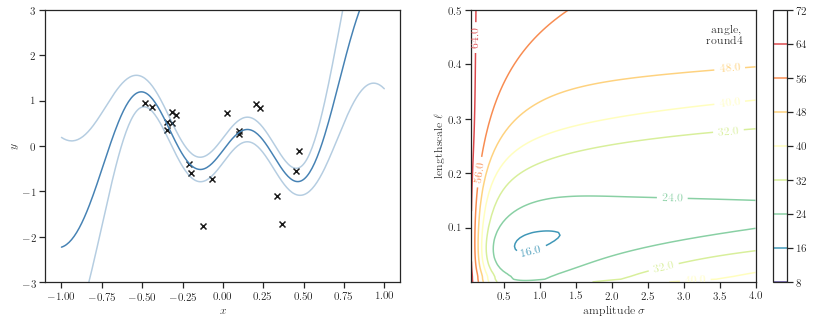

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))

line_mean, = ax1.plot(X_q, gprm_mean_value[0], c="steelblue")
line_stddev_lower, = ax1.plot(X_q, gprm_mean_value[0] - 3*gprm_stddev_value[0], 
                              c="steelblue", alpha=0.4)
line_stddev_upper, = ax1.plot(X_q, gprm_mean_value[0] + 3*gprm_stddev_value[0], 
                              c="steelblue", alpha=0.4)

ax1.scatter(X, Y, marker='x', color='k', label="noisy observations")

ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_ylim(-3, 3)

_amplitude_grid, _length_scale_grid = np.broadcast_arrays(amplitude_grid, length_scale_grid)
contours = ax2.contour(_amplitude_grid, _length_scale_grid, nll_grid_value, cmap="Spectral_r")

path, = ax2.plot([], [], c='k')
point, = ax2.plot([], [], 'ko')

text = ax2.annotate('angle,\nround4',
                    xy=(0.95, 0.95), xycoords='axes fraction',
                    ha="right", va="top",
                    bbox=dict(boxstyle="round", fc="1.0"))

fig.colorbar(contours, ax=ax2)
ax2.clabel(contours, fmt='%.1f')

ax2.set_xlabel(r"amplitude $\sigma$")
ax2.set_ylabel(r"lengthscale $\ell$")

plt.show()

In [18]:
def animate(i):

    line_mean.set_data(X_q, gprm_mean_value[i])
    line_stddev_lower.set_data(X_q, gprm_mean_value[i] - 3*gprm_stddev_value[i])
    line_stddev_upper.set_data(X_q, gprm_mean_value[i] + 3*gprm_stddev_value[i])

    path.set_data(history["amplitude"][:i], history["length_scale"][:i])
    point.set_data(history["amplitude"][i], history["length_scale"][i])

    text.set_text("epoch: {i:3d}\nnll: {nll:.2f}".format(i=i, nll=history["nll"][i]))

    return line_mean, line_stddev_lower, line_stddev_upper, path, point, text

In [19]:
anim = animation.FuncAnimation(fig, animate, frames=num_epochs,
                               interval=60, repeat_delay=5, blit=True)

In [20]:
HTML(anim.to_html5_video())

## GP prior samples animated 

In [21]:
gp_history = tfd.GaussianProcess(kernel=kernel_history, index_points=X_q, jitter=jitter)
gp_history_samples = gp_sample_custom(gp_history, n_samples, seed=seed)

In [22]:
with tf.Session() as sess:
    gp_history_samples_value = sess.run(gp_history_samples)

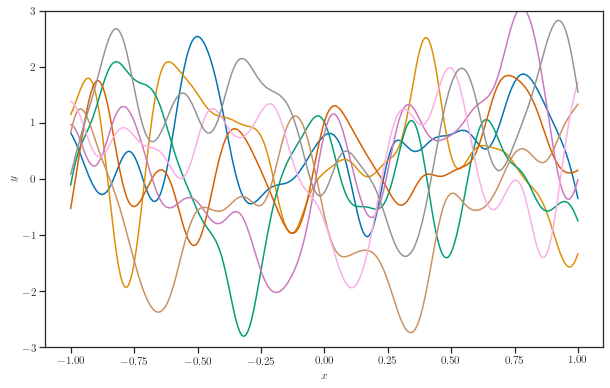

In [23]:
fig, ax = plt.subplots()

lines = ax.plot(X_q, gp_history_samples_value[::, -1].T)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_ylim(-3, 3)

plt.show()

In [24]:
def animate(i):
    for j, line in enumerate(lines):
        line.set_data(X_q, gp_history_samples_value[j, i])
    return lines

In [25]:
anim = animation.FuncAnimation(fig, animate, frames=num_epochs, 
                               interval=60, repeat_delay=5, blit=True)

In [26]:
HTML(anim.to_html5_video())